In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import pickle
import time
from keras import backend as K
from sklearn.model_selection import cross_val_score
from sklearn.tree import ExtraTreeRegressor
from sklearn.metrics import r2_score
#from multiprocessing import Pool,cpu_count
import sklearn.metrics as m
from collections import Counter
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [161]:
'''
Function that takes in a dataframe and then returns the dictionary of accuracies.
'''

def plot_test(y_test,y_pred,start,end):
     #Plot of testing.
     plt.figure(figsize=(10,10))
     plt.plot(y_test[start:end])
     plt.plot(y_pred[start:end])
     plt.xticks(np.arange(0,end-start,1))
     plt.legend()
     plt.show()

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_pred - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def create_df(localdf):
    i=0
    newdf = []
    timestamp = []
    d = np.zeros((7,))
    newhr = []
    while(24*(i+1)<localdf.shape[0]):
        #print (np.shape(np.sum(localdf.values[24*i:24*(i+1),1:],axis=0).reshape(7,1)),np.sum(localdf.values[24*i:24*(i+1),1:],axis=0).reshape(7,1))
        d = np.sum(localdf.values[24*i:24*(i+1),1:],axis=0)
        newhr.append(localdf.values[24*i:24*(i+1),-1])
        timestamp.append(localdf.values[24*i,0])
        newdf.append(d.T)
        i += 1
    
    print ("End i: ",i)
    newdf = np.hstack((np.reshape(timestamp,(-1,1)),newdf))
    print (newdf)
    return newdf,newhr
  


def nn_model(localdf,localdict,times,metric,num_cols,hour_day):
    for counter in range(times):
            #i = num_cols
        #for i in range(num_cols):
            i=num_cols
            df = pd.DataFrame()
            if(i != 0):
                print(localdf.columns[i])
                df = localdf[localdf.columns[i]]
                
                #ndf = pd.concat([df.shift(24),df.shift(23),df.shift(22),df.shift(21),df.shift(20),df.shift(19),df.shift(18),df.shift(17),df.shift(16),df.shift(15),df.shift(14),df.shift(13),df.shift(12),df.shift(11),df.shift(10),df.shift(9),df.shift(8),df.shift(7),df.shift(6),df.shift(5),df.shift(4),df.shift(3),df.shift(2), df.shift(1), df], axis=1)
                #ndf.columns = ('t-24','t-23','t-22','t-21','t-20','t-19','t-18','t-17','t-16','t-15','t-14','t-13','t-12','t-11','t-10','t-9','t-8','t-7','t-6','t-5','t-4','t-3','t-2','t-1','t')
                #ndf = ndf.iloc[24:]
                #hour_day = hour_day.iloc[24:]
                #print (ndf.head())
                #print (ndf.tail())
                #print (ndf.columns)
                
                ndf,nhr = create_df(localdf)
                df = pd.DataFrame(ndf)
                ndf = pd.DataFrame(ndf,columns = localdf.columns)
                print (ndf.shape)
                df = pd.DataFrame(ndf.values[:,7])
                
                ndf = pd.concat([df.shift(7),df.shift(6),df.shift(5),df.shift(4),df.shift(3),df.shift(2),df.shift(1)],axis=1)
                ndf.columns = ('t-7','t-6','t-5','t-4','t-3','t-2','t-1')

                
                #Drop the first seven rows of newdf.
                nhr = nhr[7:]
                ndf = ndf[:ndf.shape[0]-7]
                
                newdata = pd.DataFrame(np.hstack((nhr,ndf)))
                newop = ndf.values[:,1]
                print (newdata.head())
                
                x = ndf
                
                print ("\n",x[:10])
                y = newop
                ndf = pd.concat([ndf,hour_day],axis=1)
                #x = pd.concat([x,hour_day],axis=1)
                print ("\n",y.shape)
                #x = ndf[ndf.columns[0:24]]
                #print (x.shape)
                #print (y.shape)
                
                #X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)
                train_size = int(70*x.shape[0]/100)
                X_train = x[:train_size]
                y_train = y[:train_size]
                    
                X_test = x[train_size:]
                y_test = y[train_size:]
                model = Sequential()
                model.add(Dense(25,input_dim=31,kernel_initializer='normal', activation='relu'))
                #Output Layer.
                model.add(Dense(24,kernel_initializer='normal'))
                #Compile model.
                model.compile(loss='mean_squared_error',optimizer='adam',metrics=[metric])
                #Fit the model.
                history = model.fit(X_train,y_train,epochs=200,batch_size=200,verbose=1)
                #Final Evaluation of the model.
                #model.evaluate returns the 'loss' and the 'metrics' for the model.
                scores = model.evaluate(X_test,y_test,verbose=1)
                y_pred = model.predict(X_test)
                y_pred[y_pred<0]=0
                print ("R2 Score : ",r2_score(y_test,y_pred))
                #print (str(coeff_determination(y_test,y_pred)))
                print ("Metric : %.5f" % (scores[1]))
                localdict.setdefault(counter,[]).append((scores[1]))
                model.summary()
    return localdict,history,y_test,y_pred,scores           

In [157]:
new_df,newhr = create_df(df_new_thermal)
newhr = np.array(newhr)
newhr.shape

End i:  1700
[['2013-03-23 08:00:00-05' 0.0 0.0 ..., 502.5333333333333 2567.916666666667
  3212.866666666667]
 ['2013-03-24 08:00:00-05' 0.0 0.0 ..., 2967.8499999999995 1473.55
  8623.516666666666]
 ['2013-03-25 08:00:00-05' 0.15 0.3833333333333333 ..., 3787.1333333333337
  5991.666666666666 20200.399999999998]
 ..., 
 ['2017-11-14 07:00:00-06' 0.0 0.8166666666666665 ..., 120.03333333333333
  823.2333333333331 1065.6666666666665]
 ['2017-11-15 07:00:00-06' 0.0 1.5666666666666667 ..., 120.26666666666667
  1234.8333333333333 1478.8]
 ['2017-11-16 07:00:00-06' 0.0 0.6833333333333333 ..., 120.03333333333333
  823.2666666666665 1065.35]]


(1700, 24)

In [162]:
thermal_dict = {}
model_history = {}
local_scores=[]
ti = time.time()
thermal_dict1,model_history1,y_test1,y_pred1 = nn_model(df_new_thermal,thermal_dict,1,"mean_squared_error",7,day_hour)
print (df_new_thermal)

total_thermal_load
End i:  1700
[['2013-03-23 08:00:00-05' 0.0 0.0 ..., 502.5333333333333 2567.916666666667
  3212.866666666667]
 ['2013-03-24 08:00:00-05' 0.0 0.0 ..., 2967.8499999999995 1473.55
  8623.516666666666]
 ['2013-03-25 08:00:00-05' 0.15 0.3833333333333333 ..., 3787.1333333333337
  5991.666666666666 20200.399999999998]
 ..., 
 ['2017-11-14 07:00:00-06' 0.0 0.8166666666666665 ..., 120.03333333333333
  823.2333333333331 1065.6666666666665]
 ['2017-11-15 07:00:00-06' 0.0 1.5666666666666667 ..., 120.26666666666667
  1234.8333333333333 1478.8]
 ['2017-11-16 07:00:00-06' 0.0 0.6833333333333333 ..., 120.03333333333333
  823.2666666666665 1065.35]]
(1700, 8)
        0        1        2        3        4        5        6        7   \
0  16.6667    15.35   169.95   198.15       16       16       16       16   
1  15.9333       16  447.717       16       16       16    16.55       16   
2    15.75       16       16       16       16       16  932.917       16   
3  1201.13       16   

ValueError: Error when checking input: expected dense_11_input to have shape (None, 31) but got array with shape (1185, 7)

In [3]:
df=pickle.load(open("/home/sfroot/TherML/DataSets/New_Pecan_Street/load_data_1632.pkl",'rb'),encoding='latin1')
df_new=df

In [4]:
df_new.head()

,dataid,localhour,use,air1,air2,air3,airwindowunit1,aquarium1,bathroom1,bathroom2,...,refrigerator1,refrigerator2,security1,shed1,sprinkler1,utilityroom1,venthood1,waterheater1,waterheater2,winecooler1
0,1632,2013-03-15 01:00:00-05,0.820433,0.0,0.0,0.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,1632,2013-03-15 02:00:00-05,0.373833,0.0,0.0,0.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,1632,2013-03-15 03:00:00-05,0.379117,0.0,0.0,0.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,1632,2013-03-15 04:00:00-05,0.341650,0.0,0.0,0.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,1632,2013-03-15 05:00:00-05,0.379400,0.0,0.0,0.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [5]:
pos=[]
for i in range(3,len(df.columns)):
    if (np.sum(np.isnan(df.iloc[:,i].values))>=40995):
        print ('Empty Column')
        pos.append(i)
    else:
        print ('All fine')
        

All fine
All fine
All fine
Empty Column
Empty Column
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
Empty Column
Empty Column
Empty Column
All fine
All fine
All fine
All fine
Empty Column
All fine
All fine
All fine
All fine
Empty Column
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
All fine
All fine
All fine
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
Empty Column
All fine
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
Empty Column
Empty Column


In [6]:
df_new.drop(df_new.columns[pos], inplace=True, axis=1)

In [7]:
df.columns

Index(['dataid', 'localhour', 'use', 'air1', 'air2', 'air3', 'bathroom1',
       'clotheswasher1', 'dishwasher1', 'disposal1', 'drye1', 'dryg1',
       'furnace1', 'furnace2', 'garage1', 'garage2', 'grid', 'kitchenapp1',
       'kitchenapp2', 'lights_plugs1', 'lights_plugs2', 'lights_plugs3',
       'microwave1', 'outsidelights_plugs1', 'outsidelights_plugs2', 'range1',
       'refrigerator1', 'waterheater1'],
      dtype='object')

In [8]:
for i in range(3,len(df.columns)):
    print (df.columns[i], np.sum(np.isnan(df.iloc[:,i].values)))

air1 1
air2 1
air3 18
bathroom1 18
clotheswasher1 0
dishwasher1 0
disposal1 0
drye1 40833
dryg1 162
furnace1 18
furnace2 0
garage1 18
garage2 162
grid 1
kitchenapp1 0
kitchenapp2 0
lights_plugs1 18
lights_plugs2 18
lights_plugs3 40851
microwave1 0
outsidelights_plugs1 1
outsidelights_plugs2 1
range1 40851
refrigerator1 7942
waterheater1 18


In [146]:
df.values[:,0]

array([1632, 1632, 1632, ..., 1632, 1632, 1632], dtype=object)

In [10]:
nuls={}
l=0
for i in range(3,len(df.columns)):
    a=df.iloc[:,i].values
    b=[]
    for j in range (len(a)):
        if np.isnan(a[j])==1:
            b.append(j)
    string = str(i)+"-"+str(np.sum(np.isnan(a)))
    nuls[string]=b


In [28]:
nuls

{'10-40833': [162,
  163,
  164,
  165,
  166,
  167,
  168,
  169,
  170,
  171,
  172,
  173,
  174,
  175,
  176,
  177,
  178,
  179,
  180,
  181,
  182,
  183,
  184,
  185,
  186,
  187,
  188,
  189,
  190,
  191,
  192,
  193,
  194,
  195,
  196,
  197,
  198,
  199,
  200,
  201,
  202,
  203,
  204,
  205,
  206,
  207,
  208,
  209,
  210,
  211,
  212,
  213,
  214,
  215,
  216,
  217,
  218,
  219,
  220,
  221,
  222,
  223,
  224,
  225,
  226,
  227,
  228,
  229,
  230,
  231,
  232,
  233,
  234,
  235,
  236,
  237,
  238,
  239,
  240,
  241,
  242,
  243,
  244,
  245,
  246,
  247,
  248,
  249,
  250,
  251,
  252,
  253,
  254,
  255,
  256,
  257,
  258,
  259,
  260,
  261,
  262,
  263,
  264,
  265,
  266,
  267,
  268,
  269,
  270,
  271,
  272,
  273,
  274,
  275,
  276,
  277,
  278,
  279,
  280,
  281,
  282,
  283,
  284,
  285,
  286,
  287,
  288,
  289,
  290,
  291,
  292,
  293,
  294,
  295,
  296,
  297,
  298,
  299,
  300,
  301,
  302,
 

In [13]:
#After removing the entirely NULL columns.
df.isnull().sum()

dataid                      0
localhour                   0
use                         1
air1                        1
air2                        1
air3                       18
bathroom1                  18
clotheswasher1              0
dishwasher1                 0
disposal1                   0
drye1                   40833
dryg1                     162
furnace1                   18
furnace2                    0
garage1                    18
garage2                   162
grid                        1
kitchenapp1                 0
kitchenapp2                 0
lights_plugs1              18
lights_plugs2              18
lights_plugs3           40851
microwave1                  0
outsidelights_plugs1        1
outsidelights_plugs2        1
range1                  40851
refrigerator1            7942
waterheater1               18
dtype: int64

In [14]:
#Dropping the columns : (1) drye1 (2) lights_plugs3 (3)range1 
df.drop(df.columns[[10,21,25]],inplace=True,axis=1)

In [15]:
#After removing the entirely NULL columns.
df.isnull().sum()

dataid                     0
localhour                  0
use                        1
air1                       1
air2                       1
air3                      18
bathroom1                 18
clotheswasher1             0
dishwasher1                0
disposal1                  0
dryg1                    162
furnace1                  18
furnace2                   0
garage1                   18
garage2                  162
grid                       1
kitchenapp1                0
kitchenapp2                0
lights_plugs1             18
lights_plugs2             18
microwave1                 0
outsidelights_plugs1       1
outsidelights_plugs2       1
refrigerator1           7942
waterheater1              18
dtype: int64

In [17]:
df_thermal = df[['dataid','localhour','air1','air2','air3','furnace1','furnace2','waterheater1']]
#Removing the dataid and the localhour column from df_thermal.
del df_thermal[df_thermal.columns[0]]
print (df_thermal.shape)

(40995, 7)


In [18]:
df_thermal.isnull().sum()

localhour        0
air1             1
air2             1
air3            18
furnace1        18
furnace2         0
waterheater1    18
dtype: int64

In [19]:
df_thermal.head()

,localhour,air1,air2,air3,furnace1,furnace2,waterheater1
0,2013-03-15 01:00:00-05,0.0,0.0,0.0,0.049567,0.0,0.0
1,2013-03-15 02:00:00-05,0.0,0.0,0.0,0.048283,0.0,0.0
2,2013-03-15 03:00:00-05,0.0,0.0,0.0,0.089833,0.0,0.0
3,2013-03-15 04:00:00-05,0.0,0.0,0.0,0.047067,0.0,0.0
4,2013-03-15 05:00:00-05,0.0,0.0,0.0,0.046250,0.0,0.0


In [20]:
df_thermal = pd.DataFrame(df_thermal.values[175:],columns=df_thermal.columns)

In [21]:
df_thermal.isnull().sum()

localhour       0
air1            1
air2            1
air3            0
furnace1        0
furnace2        0
waterheater1    0
dtype: int64

In [22]:
df_thermal.iloc[34491:34494]

,localhour,air1,air2,air3,furnace1,furnace2,waterheater1
34491,2017-02-27 10:00:00-06,0,6.66667e-05,0,0.005,0.005,0
34492,2017-02-27 11:00:00-06,NaN,NaN,0,0.005,0.005,0
34493,2017-02-27 12:00:00-06,0,0,0,0.005,0.005,0


In [23]:
df_thermal.values[34492][1] = (df_thermal.iloc[34492-24*7+1][1] + df_thermal.iloc[34492+24*7+1][1]) / 2
df_thermal.values[34492][2] = (df_thermal.iloc[34292-24*7+1][2] + df_thermal.iloc[34492+24*7+1][2]) / 2

In [24]:
df_thermal.iloc[34316-24*7+1]

localhour       2017-02-13 04:00:00-06
air1                                 0
air2                                 0
air3                                 0
furnace1                         0.005
furnace2                         0.005
waterheater1                         0
Name: 34149, dtype: object

In [25]:
df_thermal.iloc[34316+24*7+1]

localhour       2017-02-27 04:00:00-06
air1                                 0
air2                                 0
air3                                 0
furnace1                         0.005
furnace2                         0.005
waterheater1                         0
Name: 34485, dtype: object

In [26]:
df_thermal.tail()

,localhour,air1,air2,air3,furnace1,furnace2,waterheater1
40815,2017-11-17 22:00:00-06,0,0,0,0.005,0.005,0
40816,2017-11-17 23:00:00-06,0,0,0,0.005,0.005,0
40817,2017-11-18 00:00:00-06,0,0,0,0.005,0.005,0
40818,2017-11-18 01:00:00-06,0,0,0,0.005,0.005,0
40819,2017-11-18 02:00:00-06,0,0,0,0.005,0.005,0


In [27]:
day_hour = np.empty([df_thermal.shape[0],1],dtype="int")
for i in range(df_thermal.shape[0]):
    day_hour[i] = df_thermal.values[i][0][11:13]

In [28]:
day_hour = pd.DataFrame(day_hour)
day_hour.columns = ["Hour of the Day"]

In [29]:
df_thermal['total_thermal_load'] = df_thermal['air1'] + df_thermal['air2'] + df_thermal['air3'] + df_thermal['furnace1'] + df_thermal['furnace2'] + df_thermal['waterheater1']

In [30]:
df_thermal.head()

,localhour,air1,air2,air3,furnace1,furnace2,waterheater1,total_thermal_load
0,2013-03-23 08:00:00-05,0,0,0,0.0059,0.01,0,0.0159
1,2013-03-23 09:00:00-05,0,0,0,0.00491667,0.01,0,0.0149167
2,2013-03-23 10:00:00-05,0,0,0,0.0059,0.0762833,0.181567,0.26375
3,2013-03-23 11:00:00-05,0,0,0,0.0059,0.0760333,1.32477,1.4067
4,2013-03-23 12:00:00-05,0,0,0,0.006,0.01,0,0.016


In [31]:
df_new_thermal = pd.DataFrame(df_thermal,columns=df_thermal.columns)

In [32]:
#Converting 'kwH' into 'Watt Hour'.
df_new_thermal.iloc[:,1:] = df_thermal.iloc[:,1:].mul(1000)

In [33]:
df_new_thermal.head()

,localhour,air1,air2,air3,furnace1,furnace2,waterheater1,total_thermal_load
0,2013-03-23 08:00:00-05,0,0,0,5.9,10,0,15.9
1,2013-03-23 09:00:00-05,0,0,0,4.91667,10,0,14.9167
2,2013-03-23 10:00:00-05,0,0,0,5.9,76.2833,181.567,263.75
3,2013-03-23 11:00:00-05,0,0,0,5.9,76.0333,1324.77,1406.7
4,2013-03-23 12:00:00-05,0,0,0,6,10,0,16


In [76]:
df_new_thermal.iloc[:,6]

0              0
1              0
2        181.567
3        1324.77
4              0
5              0
6              0
7              0
8              0
9              0
10             0
11        121.75
12           186
13             0
14             0
15             0
16             0
17        372.25
18             0
19             0
20             0
21             0
22             0
23       381.583
24             0
25             0
26             0
27             0
28             0
29             0
          ...   
40790          0
40791          0
40792          0
40793    415.317
40794          0
40795          0
40796          0
40797          0
40798          0
40799          0
40800          0
40801          0
40802     403.75
40803          0
40804          0
40805          0
40806          0
40807          0
40808          0
40809          0
40810          0
40811          0
40812          0
40813          0
40814    415.017
40815          0
40816          0
40817         

In [141]:
thermal_dict = {}
model_history = {}
local_scores=[]
ti = time.time()
thermal_dict1,model_history1,y_test1,y_pred1 = nn_model(df_new_thermal,thermal_dict,1,"mean_squared_error",7,day_hour)
print (df_new_thermal)

total_thermal_load
0
1000
End i:  1700
[['2013-03-23 08:00:00-05' 0.0 0.0 ..., 502.5333333333333 2567.916666666667
  3212.866666666667]
 ['2013-03-24 08:00:00-05' 0.0 0.0 ..., 2967.8499999999995 1473.55
  8623.516666666666]
 ['2013-03-25 08:00:00-05' 0.15 0.3833333333333333 ..., 3787.1333333333337
  5991.666666666666 20200.399999999998]
 ..., 
 ['2017-11-14 07:00:00-06' 0.0 0.8166666666666665 ..., 120.03333333333333
  823.2333333333331 1065.6666666666665]
 ['2017-11-15 07:00:00-06' 0.0 1.5666666666666667 ..., 120.26666666666667
  1234.8333333333333 1478.8]
 ['2017-11-16 07:00:00-06' 0.0 0.6833333333333333 ..., 120.03333333333333
  823.2666666666665 1065.35]]
(1700, 8)


TypeError: unhashable type: 'slice'

In [230]:
print (r2_score(y_test,y_pred))

0.805049425417


In [238]:
thermal_dict1 = {}
model_history1 = {}
ti = time.time()
thermal_dict1,model_history1,y_test1,y_pred1 = nn_model(df_thermal,thermal_dict,1,"mean_squared_error",7,day_hour)
tf = time.time()

print ("Time Taken : ",tf-ti)
print (thermal_dict1)

air1

 Index(['t-24', 't-23', 't-22', 't-21', 't-20', 't-19', 't-18', 't-17', 't-16',
       't-15', 't-14', 't-13', 't-12', 't-11', 't-10', 't-9', 't-8', 't-7',
       't-6', 't-5', 't-4', 't-3', 't-2', 't-1'],
      dtype='object')

 Index(['t-24', 't-23', 't-22', 't-21', 't-20', 't-19', 't-18', 't-17', 't-16',
       't-15', 't-14', 't-13', 't-12', 't-11', 't-10', 't-9', 't-8', 't-7',
       't-6', 't-5', 't-4', 't-3', 't-2', 't-1', 'Hour of the Day'],
      dtype='object')
(40796, 25)
(40796, 1)
Epoch 1/200
28557/28557 [==============================] - 0s - loss: 0.0654 - mean_squared_error: 0.0654     
Epoch 2/200
28557/28557 [==============================] - 0s - loss: 0.0330 - mean_squared_error: 0.0330     
Epoch 3/200
28557/28557 [==============================] - 0s - loss: 0.0303 - mean_squared_error: 0.0303     
Epoch 4/200
28557/28557 [==============================] - 0s - loss: 0.0288 - mean_squared_error: 0.0288     
Epoch 5/200
28557/28557 [==========================

28557/28557 [==============================] - 0s - loss: 0.0249 - mean_squared_error: 0.0249     
Epoch 142/200
28557/28557 [==============================] - 0s - loss: 0.0248 - mean_squared_error: 0.0248     
Epoch 143/200
28557/28557 [==============================] - 0s - loss: 0.0248 - mean_squared_error: 0.0248     
Epoch 144/200
28557/28557 [==============================] - 0s - loss: 0.0249 - mean_squared_error: 0.0249     
Epoch 145/200
28557/28557 [==============================] - 0s - loss: 0.0248 - mean_squared_error: 0.0248     
Epoch 146/200
28557/28557 [==============================] - 0s - loss: 0.0249 - mean_squared_error: 0.0249     
Epoch 147/200
28557/28557 [==============================] - 0s - loss: 0.0249 - mean_squared_error: 0.0249     
Epoch 148/200
28557/28557 [==============================] - 0s - loss: 0.0248 - mean_squared_error: 0.0248     
Epoch 149/200
28557/28557 [==============================] - 0s - loss: 0.0248 - mean_squared_error: 0.0248   

28557/28557 [==============================] - 0s - loss: 0.0390 - mean_squared_error: 0.0390     
Epoch 4/200
28557/28557 [==============================] - 0s - loss: 0.0390 - mean_squared_error: 0.0390     
Epoch 5/200
28557/28557 [==============================] - 0s - loss: 0.0390 - mean_squared_error: 0.0390     
Epoch 6/200
28557/28557 [==============================] - 0s - loss: 0.0390 - mean_squared_error: 0.0390     
Epoch 7/200
28557/28557 [==============================] - 0s - loss: 0.0390 - mean_squared_error: 0.0390     
Epoch 8/200
28557/28557 [==============================] - 0s - loss: 0.0390 - mean_squared_error: 0.0390     
Epoch 9/200
28557/28557 [==============================] - 0s - loss: 0.0390 - mean_squared_error: 0.0390     
Epoch 10/200
28557/28557 [==============================] - 0s - loss: 0.0390 - mean_squared_error: 0.0390     
Epoch 11/200
28557/28557 [==============================] - 0s - loss: 0.0390 - mean_squared_error: 0.0390     
Epoch 12/20

28557/28557 [==============================] - 0s - loss: 0.0390 - mean_squared_error: 0.0390     
Epoch 147/200
28557/28557 [==============================] - 0s - loss: 0.0390 - mean_squared_error: 0.0390     
Epoch 148/200
28557/28557 [==============================] - 0s - loss: 0.0390 - mean_squared_error: 0.0390     
Epoch 149/200
28557/28557 [==============================] - 0s - loss: 0.0390 - mean_squared_error: 0.0390     
Epoch 150/200
28557/28557 [==============================] - 0s - loss: 0.0390 - mean_squared_error: 0.0390     
Epoch 151/200
28557/28557 [==============================] - 0s - loss: 0.0390 - mean_squared_error: 0.0390     
Epoch 152/200
28557/28557 [==============================] - 0s - loss: 0.0390 - mean_squared_error: 0.0390     
Epoch 153/200
28557/28557 [==============================] - 0s - loss: 0.0390 - mean_squared_error: 0.0390     
Epoch 154/200
28557/28557 [==============================] - 0s - loss: 0.0390 - mean_squared_error: 0.0390   

28557/28557 [==============================] - 0s - loss: 0.0430 - mean_squared_error: 0.0430     
Epoch 80/200
28557/28557 [==============================] - 0s - loss: 0.0430 - mean_squared_error: 0.0430     
Epoch 81/200
28557/28557 [==============================] - 0s - loss: 0.0430 - mean_squared_error: 0.0430     
Epoch 82/200
28557/28557 [==============================] - 0s - loss: 0.0430 - mean_squared_error: 0.0430     
Epoch 83/200
28557/28557 [==============================] - 0s - loss: 0.0430 - mean_squared_error: 0.0430     
Epoch 84/200
28557/28557 [==============================] - 0s - loss: 0.0430 - mean_squared_error: 0.0430     
Epoch 85/200
28557/28557 [==============================] - 0s - loss: 0.0430 - mean_squared_error: 0.0430     
Epoch 86/200
28557/28557 [==============================] - 0s - loss: 0.0430 - mean_squared_error: 0.0430     
Epoch 87/200
28557/28557 [==============================] - 0s - loss: 0.0430 - mean_squared_error: 0.0430     
Epoch

28557/28557 [==============================] - 0s - loss: 0.2291 - mean_squared_error: 0.2291     
Epoch 13/200
28557/28557 [==============================] - 0s - loss: 0.2291 - mean_squared_error: 0.2291     
Epoch 14/200
28557/28557 [==============================] - 0s - loss: 0.2291 - mean_squared_error: 0.2291     
Epoch 15/200
28557/28557 [==============================] - 0s - loss: 0.2291 - mean_squared_error: 0.2291     
Epoch 16/200
28557/28557 [==============================] - 0s - loss: 0.2291 - mean_squared_error: 0.2291     
Epoch 17/200
28557/28557 [==============================] - 0s - loss: 0.2291 - mean_squared_error: 0.2291     
Epoch 18/200
28557/28557 [==============================] - 0s - loss: 0.2291 - mean_squared_error: 0.2291     
Epoch 19/200
28557/28557 [==============================] - 0s - loss: 0.2291 - mean_squared_error: 0.2291     
Epoch 20/200
28557/28557 [==============================] - 0s - loss: 0.2291 - mean_squared_error: 0.2291     
Epoch

28557/28557 [==============================] - 0s - loss: 0.2291 - mean_squared_error: 0.2291     
Epoch 157/200
28557/28557 [==============================] - 0s - loss: 0.2291 - mean_squared_error: 0.2291     
Epoch 158/200
28557/28557 [==============================] - 0s - loss: 0.2291 - mean_squared_error: 0.2291     
Epoch 159/200
28557/28557 [==============================] - 0s - loss: 0.2291 - mean_squared_error: 0.2291     
Epoch 160/200
28557/28557 [==============================] - 0s - loss: 0.2291 - mean_squared_error: 0.2291     
Epoch 161/200
28557/28557 [==============================] - 0s - loss: 0.2291 - mean_squared_error: 0.2291     
Epoch 162/200
28557/28557 [==============================] - 0s - loss: 0.2291 - mean_squared_error: 0.2291     
Epoch 163/200
28557/28557 [==============================] - 0s - loss: 0.2292 - mean_squared_error: 0.2292     
Epoch 164/200
28557/28557 [==============================] - 0s - loss: 0.2291 - mean_squared_error: 0.2291   

28557/28557 [==============================] - 0s - loss: 0.0056 - mean_squared_error: 0.0056     
Epoch 92/200
28557/28557 [==============================] - 0s - loss: 0.0056 - mean_squared_error: 0.0056     
Epoch 93/200
28557/28557 [==============================] - 0s - loss: 0.0056 - mean_squared_error: 0.0056     
Epoch 94/200
28557/28557 [==============================] - 0s - loss: 0.0056 - mean_squared_error: 0.0056     
Epoch 95/200
28557/28557 [==============================] - 0s - loss: 0.0056 - mean_squared_error: 0.0056     
Epoch 96/200
28557/28557 [==============================] - 0s - loss: 0.0056 - mean_squared_error: 0.0056     
Epoch 97/200
28557/28557 [==============================] - 0s - loss: 0.0056 - mean_squared_error: 0.0056     
Epoch 98/200
28557/28557 [==============================] - 0s - loss: 0.0056 - mean_squared_error: 0.0056     
Epoch 99/200
28557/28557 [==============================] - 0s - loss: 0.0056 - mean_squared_error: 0.0056     
Epoch

28557/28557 [==============================] - 0s - loss: 0.0056 - mean_squared_error: 0.0056     
Epoch 164/200
28557/28557 [==============================] - 0s - loss: 0.0056 - mean_squared_error: 0.0056     
Epoch 165/200
28557/28557 [==============================] - 0s - loss: 0.0056 - mean_squared_error: 0.0056     
Epoch 166/200
28557/28557 [==============================] - 0s - loss: 0.0056 - mean_squared_error: 0.0056     
Epoch 167/200
28557/28557 [==============================] - 0s - loss: 0.0056 - mean_squared_error: 0.0056     
Epoch 168/200
28557/28557 [==============================] - 0s - loss: 0.0056 - mean_squared_error: 0.0056     
Epoch 169/200
28557/28557 [==============================] - 0s - loss: 0.0056 - mean_squared_error: 0.0056     
Epoch 170/200
28557/28557 [==============================] - 0s - loss: 0.0056 - mean_squared_error: 0.0056     
Epoch 171/200
28557/28557 [==============================] - 0s - loss: 0.0056 - mean_squared_error: 0.0056   

28557/28557 [==============================] - 0s - loss: 0.0384 - mean_squared_error: 0.0384     
Epoch 96/200
28557/28557 [==============================] - 0s - loss: 0.0384 - mean_squared_error: 0.0384     
Epoch 97/200
28557/28557 [==============================] - 0s - loss: 0.0384 - mean_squared_error: 0.0384     
Epoch 98/200
28557/28557 [==============================] - 0s - loss: 0.0384 - mean_squared_error: 0.0384     
Epoch 99/200
28557/28557 [==============================] - 0s - loss: 0.0384 - mean_squared_error: 0.0384     
Epoch 100/200
28557/28557 [==============================] - 0s - loss: 0.0384 - mean_squared_error: 0.0384     
Epoch 101/200
28557/28557 [==============================] - 0s - loss: 0.0384 - mean_squared_error: 0.0384     
Epoch 102/200
28557/28557 [==============================] - 0s - loss: 0.0384 - mean_squared_error: 0.0384     
Epoch 103/200
28557/28557 [==============================] - 0s - loss: 0.0384 - mean_squared_error: 0.0384     
E

ValueError: too many values to unpack (expected 4)

In [232]:
print (r2_score(y_test1,y_pred1))

0.812916571621


/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


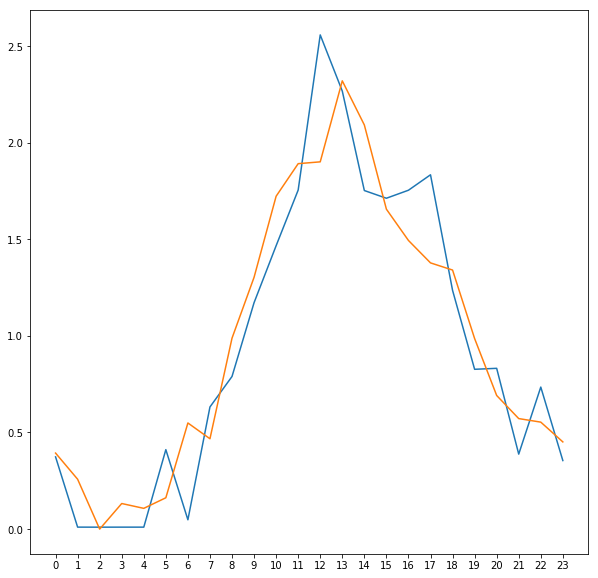

In [228]:
#Plotting the y_test VS y_pred.
plot_test(y_test,y_pred,0+24,24+24)

In [105]:
for key,val in model_history.history.items() :
    print (key)

loss
mean_squared_error


In [44]:
#With the 'metric' as 'coefficient of determination (r^2)'.
'''
water-heater attribute is always negative when r^2 is used.
'''
thermal_dict1 = thermal_dict
print (thermal_dict1)


{0: [0.57281007940777373, -1.0648682339117843, 0.4171872332889271, 0.33941760762890782, 0.2714133022580294, -32.898724590195911]}


In [33]:
#With the 'metric' as 'mean_squared_error'.
thermal_dict3 = thermal_dict
print (thermal_dict3)

{0: [0.57281007940777373, -1.0648682339117843, 0.4171872332889271, 0.33941760762890782, 0.2714133022580294, -32.898724590195911]}


In [34]:
'''
Moving on to 'Extra Trees Regresssor.
'''
def et_month(localdf):
    scores=[]
    for i in range(len(localdf.columns)):
                df = pd.DataFrame()
                if(i != 0):
                    #print(localdf.columns[i])
                    df = localdf[localdf.columns[i]]
                    ndf = pd.concat([df.shift(168), df.shift(24), df], axis=1)
                    ndf.columns = ('t-168', 't-24', 't')
                    ndf = ndf.iloc[168:]

                    x = ndf[ndf.columns[0:2]]
                    y = ndf[ndf.columns[-1:]]
                    
                    #Sequential Split.
                    train_size = int(70*x.shape[0]/100)
                    X_train = x.values[:train_size]
                    y_train = y.values[:train_size]
                    
                    X_test = x.values[train_size:]
                    y_test = y.values[train_size:]
                    
                    print (X_train.shape,y_train.shape)
                    print (X_test.shape,y_test.shape)
                    #X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)

                    model = ExtraTreeRegressor()
                    model = model.fit(X_train,y_train)
                    y_pred = model.predict(X_test)
                    #scores.append(r2_score(y_test,y_pred))
                    scores.append(m.mean_squared_error(y_test,y_pred))
                    #scores.append(cross_val_score(model,x.values,y.values,scoring='r2',cv=2))
    return scores          

In [33]:
'''
Moving on to 'Extra Trees Regresssor.
'''
def et_2hours(localdf):
    scores=[]
    for i in range(len(localdf.columns)):
                df = pd.DataFrame()
                if(i != 0):
                    #print(localdf.columns[i])
                    df = localdf[localdf.columns[i]]
                    ndf = pd.concat([df.shift(2), df.shift(1), df], axis=1)
                    ndf.columns = ('t-2', 't-1', 't')
                    ndf = ndf.iloc[2:]

                    x = ndf[ndf.columns[0:2]]
                    y = ndf[ndf.columns[-1:]]
                    
                    #Sequential Split.
                    train_size = int(70*x.shape[0]/100)
                    X_train = x.values[:train_size]
                    y_train = y.values[:train_size]
                    
                    X_test = x.values[train_size:]
                    y_test = y.values[train_size:]
                    
                    print (X_train.shape,y_train.shape)
                    print (X_test.shape,y_test.shape)
                    #X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)

                    model = ExtraTreeRegressor()
                    model = model.fit(X_train,y_train)
                    y_pred = model.predict(X_test)
                    #scores.append(r2_score(y_test,y_pred))
                    scores.append(m.mean_squared_error(y_test,y_pred))
                    #scores.append(cross_val_score(model,x.values,y.values,scoring='r2',cv=2))
    return scores          

In [37]:
'''
Moving on to 'Extra Trees Regresssor.
'''
def et_4hours(localdf):
    scores=[]
    for i in range(len(localdf.columns)):
                df = pd.DataFrame()
                if(i != 0):
                    #print(localdf.columns[i])
                    df = localdf[localdf.columns[i]]
                    ndf = pd.concat([df.shift(4),df.shift(3),df.shift(2), df.shift(1), df], axis=1)
                    ndf.columns = ('t-4','t-3','t-2', 't-1', 't')
                    ndf = ndf.iloc[4:]

                    x = ndf[ndf.columns[0:4]]
                    y = ndf[ndf.columns[-1:]]
                    
                    #Sequential Split.
                    train_size = int(70*x.shape[0]/100)
                    X_train = x.values[:train_size]
                    y_train = y.values[:train_size]

                    X_test = x.values[train_size:]
                    y_test = y.values[train_size:]
                    
                    print (X_train.shape,y_train.shape)
                    print (X_test.shape,y_test.shape)
                    
                    #X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)

                    model = ExtraTreeRegressor()
                    model = model.fit(X_train,y_train)
                    y_pred = model.predict(X_test)
                    #scores.append(r2_score(y_test,y_pred))
                    scores.append(m.mean_squared_error(y_test,y_pred))
                    #scores.append(cross_val_score(model,x.values,y.values,scoring='r2',cv=2))
    return scores          

In [31]:
#Metric : 'r^2'.
scores_2hours = et_2hours(df_thermal)
print (scores_2hours)

[array([ 0.57303293,  0.58185637]), array([ 0.36696033,  0.37221549]), array([ 0.6319369 ,  0.48454331]), array([ 0.60044037,  0.49502702]), array([ 0.46097493,  0.31680585]), array([-0.36939523, -0.24388865])]


In [32]:
#Metric : 'r^2'.
scores_4hours = et_4hours(df_thermal)
print (scores_4hours)

[array([ 0.56846882,  0.56787801]), array([ 0.39209297,  0.32989165]), array([ 0.65910766,  0.4908278 ]), array([ 0.60796577,  0.44329891]), array([-1.87280973,  0.33262254]), array([-0.4520411 , -0.40125901])]


In [33]:
#Metric : 'r^2'.
scores_month = et_month(df_thermal)
print (scores_month)

[array([ 0.37674988,  0.31931007]), array([ 0.08206034,  0.0377291 ]), array([ 0.27609219,  0.21993242]), array([-0.02126532, -0.23019628]), array([ 0.26208185, -0.18036948]), array([-0.70714878, -0.44804766])]


In [35]:
#Metric : 'mse'.
scores_2hours = et_2hours(df_thermal)
print (scores_2hours)

(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
[0.066291323054328152, 0.031763438050504807, 0.010161939693149501, 0.039744507992379517, 0.0010132881635656367, 0.037236108758228512]


In [38]:
#Metric : 'mse'.
scores_4hours = et_4hours(df_thermal)
print (scores_4hours)

(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
[0.065919164765892491, 0.031218910736631401, 0.0092476137970330663, 0.043824699368812878, 0.0010705180808068219, 0.03954773926072884]


In [40]:
df_thermal.head(10)

,localhour,air1,air2,air3,furnace1,furnace2,waterheater1
0,2013-03-23 08:00:00-05,0,0,0,0.0059,0.01,0
1,2013-03-23 09:00:00-05,0,0,0,0.00491667,0.01,0
2,2013-03-23 10:00:00-05,0,0,0,0.0059,0.0762833,0.181567
3,2013-03-23 11:00:00-05,0,0,0,0.0059,0.0760333,1.32477
4,2013-03-23 12:00:00-05,0,0,0,0.006,0.01,0
5,2013-03-23 13:00:00-05,0,0,0,0.006,0.01,0
6,2013-03-23 14:00:00-05,0,0,0,0.006,0.01,0
7,2013-03-23 15:00:00-05,0,0,0,0.006,0.01,0
8,2013-03-23 16:00:00-05,0,0,0,0.006,0.01,0
9,2013-03-23 17:00:00-05,0,0,0,0.006,0.01,0


In [34]:
df_thermal.to_csv("df_thermal.csv",encoding="utf8")

In [35]:
for i in df_thermal.columns:
    print (np.amax(df_thermal[i]))

2017-11-18 02:00:00-06
2.399916666666667
1.9250166666666668
1.5737333333333332
5.048083333333333
1.0207
1.9665833333333331


In [46]:
df_thermal.shape

(40820, 7)

In [45]:
df_thermal.tail(10)

,localhour,air1,air2,air3,furnace1,furnace2,waterheater1
40810,2017-11-17 17:00:00-06,0,0,0,0.005,0.005,0
40811,2017-11-17 18:00:00-06,0,0,0,0.005,0.005,0
40812,2017-11-17 19:00:00-06,0,0,0,0.005,0.005,0
40813,2017-11-17 20:00:00-06,0,0,0,0.005,0.005,0
40814,2017-11-17 21:00:00-06,0,0,0.00055,0.00515,0.005,0.415017
40815,2017-11-17 22:00:00-06,0,0,0,0.005,0.005,0
40816,2017-11-17 23:00:00-06,0,0,0,0.005,0.005,0
40817,2017-11-18 00:00:00-06,0,0,0,0.005,0.005,0
40818,2017-11-18 01:00:00-06,0,0,0,0.005,0.005,0
40819,2017-11-18 02:00:00-06,0,0,0,0.005,0.005,0


In [ ]:
days = ['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
columns = np.empty([df_thermal.shape[0],1],dtype=str)
i=0
while i <= (df_thermal.shape[0]-7):
    columns[i]   = 'Saturday'
    columns[i+1] = 'Sunday'
    columns[i+2] = 'Monday'
    columns[i+3] = 'Tuesday'
    columns[i+4] = 'Wednesday'
    columns[i+5] = 'Thursday'
    columns[i+6] = 'Friday'
    i += 7

In [54]:
print (columns[0])

['S']


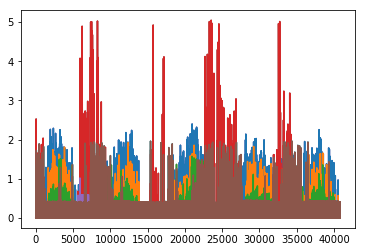

In [78]:
plt.plot(df_thermal.values[:,1:])
plt.show()

In [111]:
for i in range(df_thermal.columns.shape[0]):    
    print (np.max(df_thermal.values[:,i]) )

2017-11-18 02:00:00-06
2.399916666666667
1.9250166666666668
1.5737333333333332
5.048083333333333
1.0207
1.9665833333333331
